In [1]:
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from skopt import gp_minimize
from skopt.plots import plot_convergence

from imblearn.under_sampling import NearMiss

from collections import Counter
import joblib

In [3]:
df = pd.read_csv("data/train.csv")
print(df.shape)
df.head()

(200000, 202)


,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


0    0.89951
1    0.10049
Name: target, dtype: float64


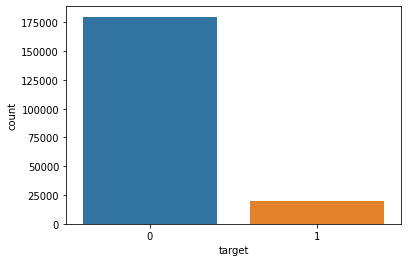

In [4]:
print(df["target"].value_counts()/df.shape[0])
sns.countplot("target", data = df)

## Undersample
* As we saw, the classes are imbalanced.
* So we will undersample the class 0 using the NearMiss approach.

In [5]:
y = df["target"]
x = df.drop(columns=["target", "ID_code"]).values

In [6]:
nm = NearMiss(version = 3, n_neighbors_ver3 = 3)
nm_x, nm_y = nm.fit_resample(x, y)

Counter({0: 20098, 1: 20098})


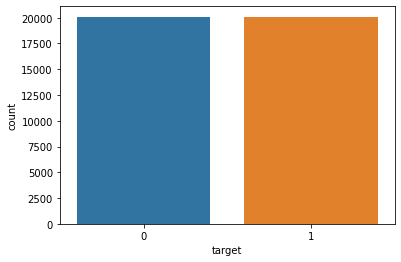

In [7]:
print(Counter(nm_y))
sns.countplot(nm_y)

# Models

In [9]:
x_train, x_test_val, y_train, y_test_val = train_test_split(nm_x, nm_y, test_size = .3, 
                                                            stratify = nm_y, random_state = 42)
x_test, x_val, y_test, y_val = train_test_split(x_test_val, y_test_val, test_size = .3, stratify = y_test_val,
                                               random_state = 42)


print("Train size: %i"%(len(y_train)))
print("Test size: %i"%(len(y_test)))
print("Validation size: %i"%(len(y_val)))

Train size: 28137
Test size: 8441
Validation size: 3618


## SGD

#### Baseline

In [11]:
baseline_sgd_pipeline = Pipeline([("scaler", MaxAbsScaler()),
                                  ("sgd", SGDClassifier(loss = "log", random_state = 42))
                                 ])
baseline_sgd_pipeline.fit(x_train, y_train)

y_pred = baseline_sgd_pipeline.predict(x_test)
print(classification_report(y_test, y_pred))

y_pred_prob = baseline_sgd_pipeline.predict_proba(x_test)[:,1]
print("ROC AUC: %f"%(roc_auc_score(y_test, y_pred_prob)))
print("AUPRC: %f"%(average_precision_score(y_test, y_pred_prob)))

              precision    recall  f1-score   support

           0       0.71      0.84      0.77      4221
           1       0.80      0.65      0.72      4220

    accuracy                           0.75      8441
   macro avg       0.76      0.75      0.74      8441
weighted avg       0.76      0.75      0.74      8441

ROC AUC: 0.834020
AUPRC: 0.836735


#### Optimize

In [12]:
def create_sgd(params):
    penalty = params[0]
    max_iter = params[1]
    alpha = params[2]
    
    sgd_pipeline =  Pipeline([("scaler", MaxAbsScaler()),
                     ("sgd", SGDClassifier(loss = "log", penalty = penalty, 
                                           max_iter= max_iter, alpha = alpha, 
                                           random_state = 42))
                    ])
    
    return sgd_pipeline

def train_sgd(params):
    print("\n", params)
    
    sgd_pipeline = create_sgd(params)
    
    sgd_pipeline.fit(x_train, y_train)
    
    y_percs = sgd_pipeline.predict_proba(x_test)[:,1]
    
    return -roc_auc_score(y_test, y_percs)
    
params = [(["l1", "l2"]), #penalty
          (500, 10000), #max_iter
          (1e-5, 1e-1, "log-uniform") #alpha
         ]

gp_sgd = gp_minimize(train_sgd, params, verbose = 1, n_calls = 50, n_random_starts = 10, random_state = 42)

Iteration No: 1 started. Evaluating function at random point.

 ['l2', 2243, 0.013145103232150136]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.3662
Function value obtained: -0.8032
Current minimum: -0.8032
Iteration No: 2 started. Evaluating function at random point.

 ['l2', 4735, 2.5113061677390027e-05]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 2.3066
Function value obtained: -0.8374
Current minimum: -0.8374
Iteration No: 3 started. Evaluating function at random point.

 ['l1', 3670, 3.727925903376984e-05]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 3.7407
Function value obtained: -0.8372
Current minimum: -0.8374
Iteration No: 4 started. Evaluating function at random point.

 ['l2', 1036, 0.007726718477963435]
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.3976
Function value obtained: -0.8087
Current minimum: -0.8374
Iteration No: 5 started. Evaluating function at random point.

 ['l2'

Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 4.5533
Function value obtained: -0.8371
Current minimum: -0.8375
Iteration No: 36 started. Searching for the next optimal point.

 ['l1', 10000, 2.3325752536835006e-05]
Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 4.7678
Function value obtained: -0.8372
Current minimum: -0.8375
Iteration No: 37 started. Searching for the next optimal point.

 ['l1', 10000, 2.2788079678830377e-05]
Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 4.5374
Function value obtained: -0.8371
Current minimum: -0.8375
Iteration No: 38 started. Searching for the next optimal point.

 ['l1', 10000, 2.404326781253701e-05]
Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 4.7203
Function value obtained: -0.8373
Current minimum: -0.8375
Iteration No: 39 started. Searching for the next optimal point.

 ['l1', 10000, 2.376407643686632e-05]


/home/marcelo/.local/share/virtualenvs/Santander-Customer-Transaction-Prediction-19m_XO-N/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 4.7507
Function value obtained: -0.8372
Current minimum: -0.8375
Iteration No: 40 started. Searching for the next optimal point.

 ['l1', 10000, 2.1701245193665628e-05]
Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 4.7845
Function value obtained: -0.8368
Current minimum: -0.8375
Iteration No: 41 started. Searching for the next optimal point.

 ['l1', 10000, 2.3660952772478366e-05]
Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 4.8292
Function value obtained: -0.8371
Current minimum: -0.8375
Iteration No: 42 started. Searching for the next optimal point.

 ['l2', 10000, 2.187400832841573e-05]
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 3.1069
Function value obtained: -0.8373
Current minimum: -0.8375
Iteration No: 43 started. Searching for the next optimal point.

 ['l2', 10000, 2.2939274841305434e-05]
Itera

['l2', 10000, 2.6772376427591386e-05]


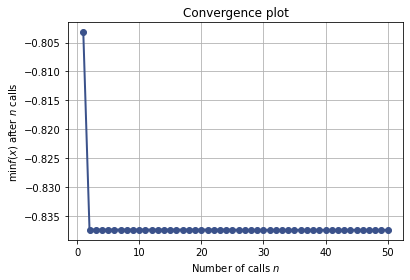

In [13]:
print(gp_sgd.x)
plot_convergence(gp_sgd)

#### Select variables

K = 5 -> ROC AUC 0.632497
K = 10 -> ROC AUC 0.670351
K = 15 -> ROC AUC 0.696303
K = 20 -> ROC AUC 0.719319
K = 25 -> ROC AUC 0.739769
K = 30 -> ROC AUC 0.752501
K = 35 -> ROC AUC 0.764492
K = 40 -> ROC AUC 0.773132
K = 45 -> ROC AUC 0.780570
K = 50 -> ROC AUC 0.786604
K = 55 -> ROC AUC 0.792790
K = 60 -> ROC AUC 0.797154
K = 65 -> ROC AUC 0.804518
K = 70 -> ROC AUC 0.808224
K = 75 -> ROC AUC 0.812244
K = 80 -> ROC AUC 0.814350
K = 85 -> ROC AUC 0.816075
K = 90 -> ROC AUC 0.818128
K = 95 -> ROC AUC 0.820328
K = 100 -> ROC AUC 0.822470
K = 105 -> ROC AUC 0.826042
K = 110 -> ROC AUC 0.826226
K = 115 -> ROC AUC 0.828975
K = 120 -> ROC AUC 0.830345
K = 125 -> ROC AUC 0.831952
K = 130 -> ROC AUC 0.833265
K = 135 -> ROC AUC 0.834591
K = 140 -> ROC AUC 0.833101
K = 145 -> ROC AUC 0.835909
K = 150 -> ROC AUC 0.836704
K = 155 -> ROC AUC 0.836743
K = 160 -> ROC AUC 0.836695
K = 165 -> ROC AUC 0.837387
K = 170 -> ROC AUC 0.837617
K = 175 -> ROC AUC 0.837613
K = 180 -> ROC AUC 0.837631
K = 185 -> R

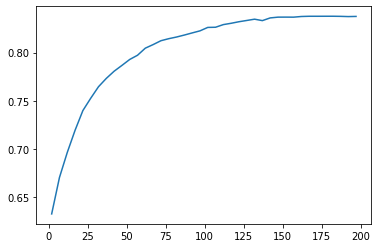

In [57]:
k_scores = []
for k in range(5, 201, 5):
    selector = SelectKBest(f_classif, k = k)
    
    x_train_selected = selector.fit_transform(x_train, y_train)
    x_test_selected = selector.transform(x_test)
    
    sgd_pipeline_selected = create_sgd(gp_sgd.x)
    sgd_pipeline_selected.fit(x_train_selected, y_train)
    
    y_percs_selected = sgd_pipeline_selected.predict_proba(x_test_selected)[:,1]
    
    roc_score = roc_auc_score(y_test, y_percs_selected)
    k_scores.append(roc_score)
    
    print("K = %i -> ROC AUC %f"%(k, roc_score))

ind = k_scores.index(max(k_scores))
opt_k = 5 + 5 * ind
print("Max score = %f; K = %i"%(k_scores[ind], opt_k))

sns.lineplot(x = range(2, 201, 5), y = k_scores)

In [58]:
selector_sgd = SelectKBest(f_classif, k = opt_k)
x_train_sgd = selector_sgd.fit_transform(x_train, y_train)

df_sgd = df.drop(columns=["target", "ID_code"]).iloc[:, selector_sgd.get_support()]

print("Removed cols ->", set(df.columns) - set(df_sgd.columns))
df_sgd.head()

Removed cols -> {'var_176', 'var_103', 'var_41', 'var_117', 'var_185', 'var_69', 'var_124', 'var_100', 'ID_code', 'var_39', 'target', 'var_30', 'var_126', 'var_38', 'var_14', 'var_183', 'var_17'}


,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


#### Opt SGD model

In [87]:
x_test_sgd = selector_sgd.transform(x_test)
x_val_sgd = selector_sgd.transform(x_val)
    
opt_sgd_pipeline = create_sgd(gp_sgd.x)
opt_sgd_pipeline.fit(x_train_sgd, y_train)

Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('sgd',
                 SGDClassifier(alpha=2.6772376427591386e-05, loss='log',
                               max_iter=10000, random_state=42))])

#### Testing model

              precision    recall  f1-score   support

           0       0.68      0.88      0.77      4221
           1       0.84      0.59      0.69      4220

    accuracy                           0.74      8441
   macro avg       0.76      0.74      0.73      8441
weighted avg       0.76      0.74      0.73      8441

ROC AUC: 0.837644
AUPRC: 0.839933


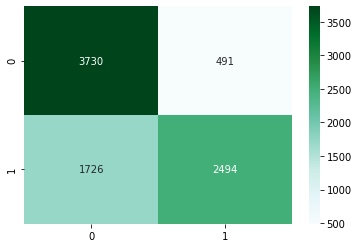

In [88]:
y_pred = opt_sgd_pipeline.predict(x_test_sgd)
print(classification_report(y_test, y_pred))

y_pred_prob = opt_sgd_pipeline.predict_proba(x_test_sgd)[:,1]
print("ROC AUC: %f"%(roc_auc_score(y_test, y_pred_prob)))
print("AUPRC: %f"%(average_precision_score(y_test, y_pred_prob)))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap = "BuGn")

#### Validating model

              precision    recall  f1-score   support

           0       0.69      0.87      0.77      1809
           1       0.83      0.61      0.70      1809

    accuracy                           0.74      3618
   macro avg       0.76      0.74      0.74      3618
weighted avg       0.76      0.74      0.74      3618

ROC AUC: 0.835641
AUPRC: 0.837468


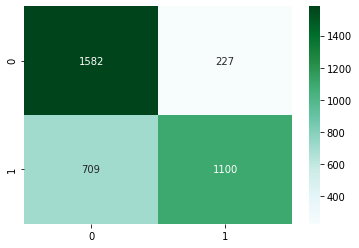

In [89]:
y_pred = opt_sgd_pipeline.predict(x_val_sgd)
print(classification_report(y_val, y_pred))

y_pred_prob = opt_sgd_pipeline.predict_proba(x_val_sgd)[:,1]
print("ROC AUC: %f"%(roc_auc_score(y_val, y_pred_prob)))
print("AUPRC: %f"%(average_precision_score(y_val, y_pred_prob)))

sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt="d", cmap = "BuGn")

## XGBoost

#### Baseline

In [76]:
baseline_xgb_pipeline = Pipeline([("scaler", MaxAbsScaler()),
                                  ("gb", XGBClassifier(random_state = 42))
                                 ])
baseline_xgb_pipeline.fit(x_train, y_train)

y_pred = baseline_xgb_pipeline.predict(x_test)
print(classification_report(y_test, y_pred))

y_pred_prob = baseline_xgb_pipeline.predict_proba(x_test)[:,1]
print("ROC AUC: %f"%(roc_auc_score(y_test, y_pred_prob)))
print("AUPRC: %f"%(average_precision_score(y_test, y_pred_prob)))

              precision    recall  f1-score   support

           0       0.78      0.79      0.79      4221
           1       0.79      0.77      0.78      4220

    accuracy                           0.78      8441
   macro avg       0.78      0.78      0.78      8441
weighted avg       0.78      0.78      0.78      8441

ROC AUC: 0.863066
AUPRC: 0.866712


#### Optimize

In [141]:
def create_xgb(params):
    learning_rate = params[0]
    max_depth = params[1]
    subsample = params[2]
    colsample_bytree = params[3]
    max_leaves = params[4]
    min_child_weight = params[5]
    
    xgb_pipeline =  Pipeline([("scaler", MaxAbsScaler()),
                     ("gb", XGBClassifier(random_state = 42, 
                                          learning_rate = learning_rate, 
                                          max_depth = max_depth, 
                                          subsample = subsample,
                                          colsample_bytree = colsample_bytree,
                                          max_leaves = max_leaves, 
                                          min_child_weight = min_child_weight))
                    ])
    
    return xgb_pipeline

def train_xgb(params):
    print("\n", params)
    
    xgb_pipeline = create_xgb(params)
    
    xgb_pipeline.fit(x_train, y_train)
    
    y_percs = xgb_pipeline.predict_proba(x_test)[:,1]
    
    return -roc_auc_score(y_test, y_percs)
    
params = [(1e-3, 1e-1, "log-uniform"), #learning_rate
          (1, 50), #max_depth
          (0.01, .95), #subsample
          (0.01, .95), #colsample_bytree
          (2, 512), #max_leaves
          (1, 120) #min_child_weight
         ]

gp_xgb = gp_minimize(train_xgb, params, verbose = 1, n_calls = 65, n_random_starts = 15, random_state = 42)

Iteration No: 1 started. Evaluating function at random point.

 [0.03918194347141743, 10, 0.7429095402564033, 0.5710391484696978, 229, 13]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 30.5321
Function value obtained: -0.8558
Current minimum: -0.8558
Iteration No: 2 started. Evaluating function at random point.

 [0.008288916866885144, 17, 0.14429480884662435, 0.6218351645719218, 31, 87]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 8.4057
Function value obtained: -0.7560
Current minimum: -0.8558
Iteration No: 3 started. Evaluating function at random point.

 [0.07535384509295551, 1, 0.9426788657337446, 0.5904326190500536, 314, 2]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 3.8678
Function value obtained: -0.7690
Current minimum: -0.8558
Iteration No: 4 started. Evaluating function at random point.

 [0.0011120513715710632, 27, 0.38586931341234026, 0.053865723420798504, 499, 29]
Iteration No: 4 ended. Evaluation done a

Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 7.7804
Function value obtained: -0.6321
Current minimum: -0.8718
Iteration No: 31 started. Searching for the next optimal point.

 [0.002106108735297139, 29, 0.5905781070289946, 0.19288217620337084, 373, 5]
Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 28.8666
Function value obtained: -0.8688
Current minimum: -0.8718
Iteration No: 32 started. Searching for the next optimal point.

 [0.0016270295769621422, 34, 0.5769078972166415, 0.13320304123382498, 175, 51]
Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 16.0285
Function value obtained: -0.8701
Current minimum: -0.8718
Iteration No: 33 started. Searching for the next optimal point.

 [0.0030075528443864017, 31, 0.33391411823751393, 0.07739281476162432, 368, 1]
Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 13.5318
Function value obtained: -0.8101
Current mini

Iteration No: 59 ended. Search finished for the next optimal point.
Time taken: 18.0509
Function value obtained: -0.8826
Current minimum: -0.8841
Iteration No: 60 started. Searching for the next optimal point.

 [0.1, 37, 0.6032648349930354, 0.15256678555784867, 65, 26]
Iteration No: 60 ended. Search finished for the next optimal point.
Time taken: 17.2164
Function value obtained: -0.8840
Current minimum: -0.8841
Iteration No: 61 started. Searching for the next optimal point.

 [0.1, 34, 0.6065522270964068, 0.15404326883202624, 481, 27]
Iteration No: 61 ended. Search finished for the next optimal point.
Time taken: 25.1621
Function value obtained: -0.8823
Current minimum: -0.8841
Iteration No: 62 started. Searching for the next optimal point.

 [0.1, 35, 0.6030163686182769, 0.14520216149095377, 92, 30]
Iteration No: 62 ended. Search finished for the next optimal point.
Time taken: 24.6156
Function value obtained: -0.8854
Current minimum: -0.8854
Iteration No: 63 started. Searching for 

[0.1, 35, 0.6030163686182769, 0.14520216149095377, 92, 30]


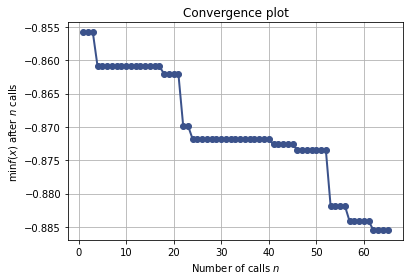

In [142]:
print(gp_xgb.x)
plot_convergence(gp_xgb)

#### Select variables

K = 5 -> ROC AUC 0.634540
K = 10 -> ROC AUC 0.676326
K = 15 -> ROC AUC 0.719413
K = 20 -> ROC AUC 0.742369
K = 25 -> ROC AUC 0.767648
K = 30 -> ROC AUC 0.795522
K = 35 -> ROC AUC 0.807121
K = 40 -> ROC AUC 0.818225
K = 45 -> ROC AUC 0.825141
K = 50 -> ROC AUC 0.831921
K = 55 -> ROC AUC 0.839192
K = 60 -> ROC AUC 0.844352
K = 65 -> ROC AUC 0.851044
K = 70 -> ROC AUC 0.854941
K = 75 -> ROC AUC 0.859733
K = 80 -> ROC AUC 0.866248
K = 85 -> ROC AUC 0.869039
K = 90 -> ROC AUC 0.866960
K = 95 -> ROC AUC 0.869136
K = 100 -> ROC AUC 0.872162
K = 105 -> ROC AUC 0.874518
K = 110 -> ROC AUC 0.877586
K = 115 -> ROC AUC 0.877631
K = 120 -> ROC AUC 0.880987
K = 125 -> ROC AUC 0.880538
K = 130 -> ROC AUC 0.884613
K = 135 -> ROC AUC 0.880759
K = 140 -> ROC AUC 0.878851
K = 145 -> ROC AUC 0.882807
K = 150 -> ROC AUC 0.882347
K = 155 -> ROC AUC 0.881071
K = 160 -> ROC AUC 0.880923
K = 165 -> ROC AUC 0.882517
K = 170 -> ROC AUC 0.881260
K = 175 -> ROC AUC 0.883771
K = 180 -> ROC AUC 0.884695
K = 185 -> R

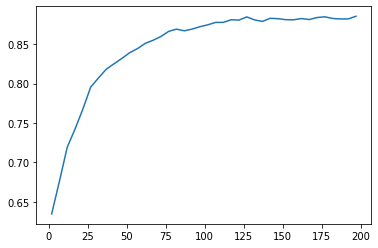

In [143]:
k_scores = []
for k in range(5, 201, 5):
    selector = SelectKBest(f_classif, k = k)
    
    x_train_selected = selector.fit_transform(x_train, y_train)
    x_test_selected = selector.transform(x_test)
    
    xgb_pipeline_selected = create_xgb(gp_xgb.x)
    xgb_pipeline_selected.fit(x_train_selected, y_train)
    
    y_percs_selected = xgb_pipeline_selected.predict_proba(x_test_selected)[:,1]
    
    roc_score = roc_auc_score(y_test, y_percs_selected)
    k_scores.append(roc_score)
    
    print("K = %i -> ROC AUC %f"%(k, roc_score))

ind = k_scores.index(max(k_scores))
opt_k = 5 + 5 * ind
print("Max score = %f; K = %i"%(k_scores[ind], opt_k))

sns.lineplot(x = range(2, 201, 5), y = k_scores)

In [144]:
selector_xgb = SelectKBest(f_classif, k = opt_k)
x_train_xgb = selector_xgb.fit_transform(x_train, y_train)

df_xgb = df.drop(columns=["target", "ID_code"]).iloc[:, selector_xgb.get_support()]

print("Removed cols ->", set(df.columns) - set(df_xgb.columns))
df_xgb.head()

Removed cols -> {'ID_code', 'target'}


,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


#### Opt XGBoost model

In [145]:
x_test_xgb = selector_xgb.transform(x_test)
x_val_xgb = selector_xgb.transform(x_val)
    
opt_xgb_pipeline = create_xgb(gp_xgb.x)
opt_xgb_pipeline.fit(x_train_xgb, y_train)

Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('gb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.14520216149095377, gamma=0,
                               gpu_id=-1, importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=35, max_leaves=92,
                               min_child_weight=30, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, random_state=42,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=0.6030163686182769,
                               tree_method='exact', validate_parameters=1,
                               verbosity=None))])

#### Testing model

              precision    recall  f1-score   support

           0       0.80      0.81      0.81      4221
           1       0.81      0.80      0.80      4220

    accuracy                           0.81      8441
   macro avg       0.81      0.81      0.81      8441
weighted avg       0.81      0.81      0.81      8441

ROC AUC: 0.885432
AUPRC: 0.888382


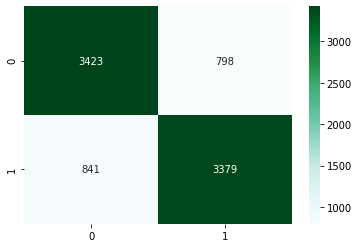

In [146]:
y_pred = opt_xgb_pipeline.predict(x_test_xgb)
print(classification_report(y_test, y_pred))

y_pred_prob = opt_xgb_pipeline.predict_proba(x_test_xgb)[:,1]
print("ROC AUC: %f"%(roc_auc_score(y_test, y_pred_prob)))
print("AUPRC: %f"%(average_precision_score(y_test, y_pred_prob)))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap = "BuGn")

#### Validating model

              precision    recall  f1-score   support

           0       0.81      0.80      0.81      1809
           1       0.80      0.81      0.81      1809

    accuracy                           0.81      3618
   macro avg       0.81      0.81      0.81      3618
weighted avg       0.81      0.81      0.81      3618

ROC AUC: 0.884005
AUPRC: 0.885259


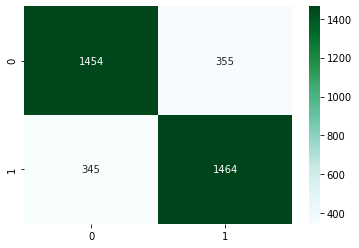

In [147]:
y_pred = opt_xgb_pipeline.predict(x_val_xgb)
print(classification_report(y_val, y_pred))

y_pred_prob = opt_xgb_pipeline.predict_proba(x_val_xgb)[:,1]
print("ROC AUC: %f"%(roc_auc_score(y_val, y_pred_prob)))
print("AUPRC: %f"%(average_precision_score(y_val, y_pred_prob)))

sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt="d", cmap = "BuGn")

## LGBM

#### Baseline

In [113]:
baseline_lgbm_pipeline = Pipeline([("scaler", MaxAbsScaler()),
                                   ("lgbm", LGBMClassifier(random_state = 42))
                                  ])
baseline_lgbm_pipeline.fit(x_train, y_train)

y_pred = baseline_lgbm_pipeline.predict(x_test)
print(classification_report(y_test, y_pred))

y_pred_prob = baseline_lgbm_pipeline.predict_proba(x_test)[:,1]
print("ROC AUC: %f"%(roc_auc_score(y_test, y_pred_prob)))
print("AUPRC: %f"%(average_precision_score(y_test, y_pred_prob)))

              precision    recall  f1-score   support

           0       0.80      0.78      0.79      4221
           1       0.79      0.80      0.79      4220

    accuracy                           0.79      8441
   macro avg       0.79      0.79      0.79      8441
weighted avg       0.79      0.79      0.79      8441

ROC AUC: 0.875513
AUPRC: 0.878407


#### Optimize

In [118]:
def create_lgbm(params):
    learning_rate = params[0]
    n_estimators = params[1]
    num_leaves = params[2]
    min_child_samples = params[3]
    subsample = params[4]
    colsample_bytree = params[5]
    
    lgbm_pipeline =  Pipeline([("scaler", MaxAbsScaler()),
                     ("lgbm", LGBMClassifier(random_state = 42, 
                                                     learning_rate = learning_rate,
                                                     n_estimators = n_estimators, 
                                                     num_leaves = num_leaves, 
                                                     min_child_samples = min_child_samples, 
                                                     subsample = subsample, 
                                                     colsample_bytree = colsample_bytree))
                    ])
    
    return lgbm_pipeline

def train_lgbm(params):
    print("\n", params)
    
    lgbm_pipeline = create_lgbm(params)
    
    lgbm_pipeline.fit(x_train, y_train)
    
    y_percs = lgbm_pipeline.predict_proba(x_test)[:,1]
    
    return -roc_auc_score(y_test, y_percs)
    
params = [(1e-3, 1e-1, 'log-uniform'), #learning_rate
          (50, 2500), #n_estimators
          (2, 256), #num_leaves
          (2, 250), #min_child_samples
          (0.05, 1.0), #subsample
          (0.05, 1.0) #colsample_bytree
         ]

gp_lgbm = gp_minimize(train_lgbm, params, verbose = 1, n_calls = 40, n_random_starts = 10, random_state = 42)

Iteration No: 1 started. Evaluating function at random point.

 [0.03918194347141743, 499, 200, 150, 0.47354111521091163, 0.14497617002710278]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 13.8223
Function value obtained: -0.8991
Current minimum: -0.8991
Iteration No: 2 started. Evaluating function at random point.

 [0.008288916866885144, 868, 38, 163, 0.10359100007574526, 0.7358988336534836]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 41.7755
Function value obtained: -0.8785
Current minimum: -0.8991
Iteration No: 3 started. Evaluating function at random point.

 [0.07535384509295551, 52, 254, 155, 0.631070502463867, 0.05671298995873154]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.2949
Function value obtained: -0.8463
Current minimum: -0.8991
Iteration No: 4 started. Evaluating function at random point.

 [0.0011120513715710632, 1336, 104, 14, 0.9750677428993865, 0.27113277340878905]
Iteration No: 4 ended. Evaluat

Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 89.1512
Function value obtained: -0.9040
Current minimum: -0.9077
Iteration No: 32 started. Searching for the next optimal point.

 [0.1, 1007, 256, 250, 1.0, 0.05]
Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 11.4521
Function value obtained: -0.9054
Current minimum: -0.9077
Iteration No: 33 started. Searching for the next optimal point.

 [0.016583860679783673, 1059, 148, 250, 1.0, 0.05]
Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 12.6511
Function value obtained: -0.9078
Current minimum: -0.9078
Iteration No: 34 started. Searching for the next optimal point.

 [0.1, 2500, 256, 250, 1.0, 1.0]
Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 260.6930
Function value obtained: -0.9029
Current minimum: -0.9078
Iteration No: 35 started. Searching for the next optimal point.

 [0.018596335284607444, 1035, 145, 25

[0.1, 2054, 256, 250, 1.0, 0.05]


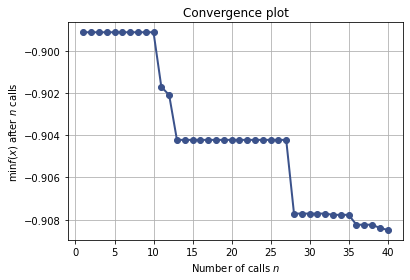

In [119]:
print(gp_lgbm.x)
plot_convergence(gp_lgbm)

#### Select variable

K = 5 -> ROC AUC 0.592162
K = 10 -> ROC AUC 0.641390
K = 15 -> ROC AUC 0.684385
K = 20 -> ROC AUC 0.702622
K = 25 -> ROC AUC 0.751600
K = 30 -> ROC AUC 0.768971
K = 35 -> ROC AUC 0.793456
K = 40 -> ROC AUC 0.788056
K = 45 -> ROC AUC 0.817658
K = 50 -> ROC AUC 0.830010
K = 55 -> ROC AUC 0.839077
K = 60 -> ROC AUC 0.844975
K = 65 -> ROC AUC 0.853562
K = 70 -> ROC AUC 0.863173
K = 75 -> ROC AUC 0.867662
K = 80 -> ROC AUC 0.866258
K = 85 -> ROC AUC 0.876805
K = 90 -> ROC AUC 0.881320
K = 95 -> ROC AUC 0.880987
K = 100 -> ROC AUC 0.885841
K = 105 -> ROC AUC 0.889584
K = 110 -> ROC AUC 0.893488
K = 115 -> ROC AUC 0.892604
K = 120 -> ROC AUC 0.894574
K = 125 -> ROC AUC 0.897448
K = 130 -> ROC AUC 0.897324
K = 135 -> ROC AUC 0.900124
K = 140 -> ROC AUC 0.900335
K = 145 -> ROC AUC 0.902136
K = 150 -> ROC AUC 0.901525
K = 155 -> ROC AUC 0.902468
K = 160 -> ROC AUC 0.896493
K = 165 -> ROC AUC 0.903771
K = 170 -> ROC AUC 0.903241
K = 175 -> ROC AUC 0.904868
K = 180 -> ROC AUC 0.906461
K = 185 -> R

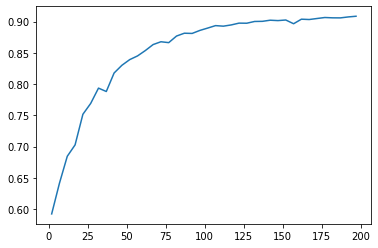

In [120]:
k_scores = []
for k in range(5, 201, 5):
    selector = SelectKBest(f_classif, k = k)
    
    x_train_selected = selector.fit_transform(x_train, y_train)
    x_test_selected = selector.transform(x_test)
    
    lgbm_pipeline_selected = create_lgbm(gp_lgbm.x)
    lgbm_pipeline_selected.fit(x_train_selected, y_train)
    
    y_percs_selected = lgbm_pipeline_selected.predict_proba(x_test_selected)[:,1]
    
    roc_score = roc_auc_score(y_test, y_percs_selected)
    k_scores.append(roc_score)
    
    print("K = %i -> ROC AUC %f"%(k, roc_score))

ind = k_scores.index(max(k_scores))
opt_k = 5 + 5 * ind
print("Max score = %f; K = %i"%(k_scores[ind], opt_k))

sns.lineplot(x = range(2, 201, 5), y = k_scores)

In [122]:
selector_lgbm = SelectKBest(f_classif, k = opt_k)
x_train_lgbm = selector_lgbm.fit_transform(x_train, y_train)

df_lgbm = df.drop(columns=["target", "ID_code"]).iloc[:, selector_lgbm.get_support()]

print("Removed cols ->", set(df.columns) - set(df_lgbm.columns))
df_lgbm.head()

Removed cols -> {'ID_code', 'target'}


,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


#### Opt LGBM model

In [123]:
x_test_lgbm = selector_lgbm.transform(x_test)
x_val_lgbm = selector_lgbm.transform(x_val)
    
opt_lgbm_pipeline = create_lgbm(gp_lgbm.x)
opt_lgbm_pipeline.fit(x_train_lgbm, y_train)

Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('lgbm',
                 LGBMClassifier(colsample_bytree=0.05, min_child_samples=250,
                                n_estimators=2054, num_leaves=256,
                                random_state=42))])

#### Testing model

              precision    recall  f1-score   support

           0       0.82      0.85      0.83      4221
           1       0.84      0.81      0.82      4220

    accuracy                           0.83      8441
   macro avg       0.83      0.83      0.83      8441
weighted avg       0.83      0.83      0.83      8441

ROC AUC: 0.908485
AUPRC: 0.914305


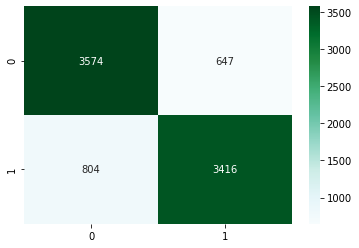

In [124]:
y_pred = opt_lgbm_pipeline.predict(x_test_lgbm)
print(classification_report(y_test, y_pred))

y_pred_prob = opt_lgbm_pipeline.predict_proba(x_test_lgbm)[:,1]
print("ROC AUC: %f"%(roc_auc_score(y_test, y_pred_prob)))
print("AUPRC: %f"%(average_precision_score(y_test, y_pred_prob)))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap = "BuGn")

#### Validating model

              precision    recall  f1-score   support

           0       0.82      0.85      0.84      1809
           1       0.84      0.82      0.83      1809

    accuracy                           0.83      3618
   macro avg       0.83      0.83      0.83      3618
weighted avg       0.83      0.83      0.83      3618

ROC AUC: 0.907754
AUPRC: 0.912392


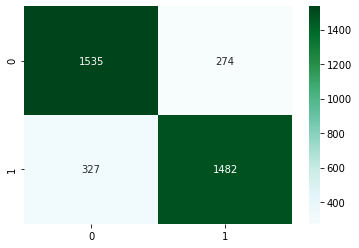

In [125]:
y_pred = opt_lgbm_pipeline.predict(x_val_lgbm)
print(classification_report(y_val, y_pred))

y_pred_prob = opt_lgbm_pipeline.predict_proba(x_val_lgbm)[:,1]
print("ROC AUC: %f"%(roc_auc_score(y_val, y_pred_prob)))
print("AUPRC: %f"%(average_precision_score(y_val, y_pred_prob)))

sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt="d", cmap = "BuGn")

## Saving Models

In [151]:
joblib.dump(opt_sgd_pipeline, "models/sgd_model.joblib")
joblib.dump(selector_sgd, "models/sgd_selector.joblib")

joblib.dump(opt_xgb_pipeline, "models/xgb_model.joblib")
joblib.dump(selector_xgb, "models/xgb_selector.joblib")

joblib.dump(opt_lgbm_pipeline, "models/lgbm_model.joblib")
joblib.dump(selector_lgbm, "models/lgbm_selector.joblib")

['models/lgbm_selector.joblib']

## Making submission predicts

In [153]:
df_test = pd.read_csv("data/test.csv")
df_test.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


In [156]:
x_sub = df_test.drop(columns = ["ID_code"])

x_sub_sgd = selector_sgd.transform(x_sub)
y_sub_sgd = opt_sgd_pipeline.predict_proba(x_sub_sgd)

x_sub_xgb = selector_xgb.transform(x_sub)
y_sub_xgb = opt_xgb_pipeline.predict_proba(x_sub_xgb)

x_sub_lgbm = selector_lgbm.transform(x_sub)
y_sub_lgbm = opt_lgbm_pipeline.predict_proba(x_sub_lgbm)

In [158]:
df_sgd = pd.DataFrame(df_test["ID_code"].copy())
df_sgd["target"] = y_sub_sgd[:,1]
df_sgd.to_csv("submission/sgd_preds.csv", index = False)

df_xgb = pd.DataFrame(df_test["ID_code"].copy())
df_xgb["target"] = y_sub_xgb[:,1]
df_xgb.to_csv("submission/xgb_preds.csv", index = False)

df_lgbm = pd.DataFrame(df_test["ID_code"].copy())
df_lgbm["target"] = y_sub_lgbm[:,1]
df_lgbm.to_csv("submission/lgbm_preds.csv", index = False)